In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [46]:
df = pd.read_csv('fight_with_stats_precomp.csv')
df_fighters = pd.read_csv('fighter_total_stats.csv')

In [47]:
df_fighters_details = pd.read_csv('fighter_details.csv', parse_dates=True)

In [48]:
df = df[(df['fightNo_fighter']>=3) & (df['fightNo_opponent']>=3) & (df['Women_fight']==0)]

In [49]:
df = df.fillna(0)


In [50]:
df.head()

,EVENT,BOUT,FIGHTER,OPPONENT,METHOD,Win,Women_fight,ROUND,HEIGHT_diff,REACH_diff,...,BODY_landed_opponent,BODY_attemps_opponent,LEG_landed_opponent,LEG_attemps_opponent,DISTANCE_landed_opponent,DISTANCE_attemps_opponent,CLINCH_landed_opponent,CLINCH_attemps_opponent,GROUND_landed_opponent,GROUND_attemps_opponent
24,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Patrick Smith,Royce Gracie,KO/TKO - ground,0,0,1,1.0,0.0,...,0.0,0.0,3.0,5.0,5.0,10.0,0.0,0.0,0.0,0.0
25,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Royce Gracie,Patrick Smith,KO/TKO - ground,1,0,1,-1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,5.0
26,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Remco Pardoel,Royce Gracie,Submission,0,0,1,2.0,0.0,...,0.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,2.0
27,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Royce Gracie,Remco Pardoel,Submission,1,0,1,-2.0,0.0,...,1.0,2.0,0.0,1.0,0.0,3.0,1.0,1.0,3.0,5.0
50,UFC 4: Revenge of the Warriors,Royce Gracie vs. Dan Severn,Dan Severn,Royce Gracie,Submission,0,0,1,1.0,0.0,...,3.0,4.0,2.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0


In [51]:
df.shape

(6817, 63)

In [52]:
df.columns.tolist()[19:]

['KD_fighter',
 'SUB.ATT_fighter',
 'REV._fighter',
 'CTRL_fighter',
 'SIG.STR._landed_fighter',
 'SIG.STR._attemps_fighter',
 'TOTAL STR._landed_fighter',
 'TOTAL STR._attemps_fighter',
 'TD_landed_fighter',
 'TD_attemps_fighter',
 'HEAD_landed_fighter',
 'HEAD_attemps_fighter',
 'BODY_landed_fighter',
 'BODY_attemps_fighter',
 'LEG_landed_fighter',
 'LEG_attemps_fighter',
 'DISTANCE_landed_fighter',
 'DISTANCE_attemps_fighter',
 'CLINCH_landed_fighter',
 'CLINCH_attemps_fighter',
 'GROUND_landed_fighter',
 'GROUND_attemps_fighter',
 'KD_opponent',
 'SUB.ATT_opponent',
 'REV._opponent',
 'CTRL_opponent',
 'SIG.STR._landed_opponent',
 'SIG.STR._attemps_opponent',
 'TOTAL STR._landed_opponent',
 'TOTAL STR._attemps_opponent',
 'TD_landed_opponent',
 'TD_attemps_opponent',
 'HEAD_landed_opponent',
 'HEAD_attemps_opponent',
 'BODY_landed_opponent',
 'BODY_attemps_opponent',
 'LEG_landed_opponent',
 'LEG_attemps_opponent',
 'DISTANCE_landed_opponent',
 'DISTANCE_attemps_opponent',
 'CLINCH

In [53]:
df = df.merge(df[['EVENT', 'BOUT', 'FIGHTER']+df.columns.tolist()[15:]] ,how='left', left_on=['EVENT', 'BOUT', 'OPPONENT'], right_on=['EVENT', 'BOUT', 'FIGHTER'], suffixes=('_f1', '_f2'))

In [54]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 112 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    EVENT                           6817 non-null   object 
 1    BOUT                            6817 non-null   object 
 2    FIGHTER_f1                      6817 non-null   object 
 3    OPPONENT                        6817 non-null   object 
 4    METHOD                          6817 non-null   object 
 5    Win                             6817 non-null   int64  
 6    Women_fight                     6817 non-null   int64  
 7    ROUND                           6817 non-null   int64  
 8    HEIGHT_diff                     6817 non-null   float64
 9    REACH_diff                      6817 non-null   float64
 10   AGE_diff                        6817 non-null   float64
 11   form_skore_fighter              6817 non-null   float64
 12   form_skore_opponen

In [55]:
df = df.drop('FIGHTER_f2',axis=1)

In [56]:
'LEG_attemps_fighter_f1'.split('_')

['LEG', 'attemps', 'fighter', 'f1']

In [57]:
sloupce1 = df.columns.tolist()[19:]
vynechat = ['Win_tot_f2', 'DRAW_f2','No_contest_f2']
sloupce = [x for x in sloupce1 if x not in vynechat]
for sloupec in sloupce:    
    splited = sloupec.split('_')
    if 'CTRL' in splited:
        df.loc[:,splited[0]+'_pct_'+splited[1]+splited[2]] = df[sloupec]/df['TotalTime'+'_'+splited[2]]
    if 'attemps' in splited:
        df.loc[:,splited[0]+'_acc_'+ splited[2] + splited[3]] = df[sloupec.replace('attemps', 'landed')]/df[sloupec]
        df.loc[:,splited[0]+'_perRound_'+ splited[2] + splited[3]] = (df[sloupec.replace('attemps', 'landed')]/df['TotalTime'+'_'+splited[3]])*300
        
    

In [58]:
df.iloc[:,:5]

,EVENT,BOUT,FIGHTER_f1,OPPONENT,METHOD
0,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Patrick Smith,Royce Gracie,KO/TKO - ground
1,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Royce Gracie,Patrick Smith,KO/TKO - ground
2,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Remco Pardoel,Royce Gracie,Submission
3,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Royce Gracie,Remco Pardoel,Submission
4,UFC 4: Revenge of the Warriors,Royce Gracie vs. Dan Severn,Dan Severn,Royce Gracie,Submission
...,...,...,...,...,...
6812,UFC Fight Night: Cannonier vs. Strickland,Jared Cannonier vs. Sean Strickland,Sean Strickland,Jared Cannonier,Decision
6813,UFC Fight Night: Cannonier vs. Strickland,Said Nurmagomedov vs. Saidyokub Kakhramonov,Said Nurmagomedov,Saidyokub Kakhramonov,Submission
6814,UFC Fight Night: Cannonier vs. Strickland,Said Nurmagomedov vs. Saidyokub Kakhramonov,Saidyokub Kakhramonov,Said Nurmagomedov,Submission
6815,UFC Fight Night: Cannonier vs. Strickland,Sergey Morozov vs. Journey Newson,Journey Newson,Sergey Morozov,Decision


In [59]:
df = df.drop(sloupce, axis=1)

In [60]:
df_model = df.drop(['EVENT','BOUT','FIGHTER_f1','OPPONENT','METHOD','Women_fight','ROUND','TotalTime_f1'],axis=1)

In [61]:
df_model = df_model.fillna(0)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Win                             6817 non-null   int64  
 1   HEIGHT_diff                     6817 non-null   float64
 2   REACH_diff                      6817 non-null   float64
 3   AGE_diff                        6817 non-null   float64
 4   form_skore_fighter              6817 non-null   float64
 5   form_skore_opponent             6817 non-null   float64
 6   fightNo_fighter                 6817 non-null   int64  
 7   fightNo_opponent                6817 non-null   float64
 8   Win_tot_f1                      6817 non-null   float64
 9   DRAW_f1                         6817 non-null   float64
 10  No_contest_f1                   6817 non-null   float64
 11  Win_tot_f2                      6817 non-null   float64
 12  DRAW_f2                         68

In [62]:
X=df_model.loc[:, ~df_model.columns.isin(['Win'])]
y=df_model['Win']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 0)
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(max_iter=50000)
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
acc = accuracy_score(y_test, predictions) 
f1 = f1_score(y_test, predictions,average='micro')
print(f1, acc)

0.5941348973607038 0.5941348973607038


In [63]:
import pandas as pd
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# načtení dat

# definice lookback
lookback = 200

# převod dat na numpy array
data = df_model.values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# rozdělení dat na trénovací a testovací
X = []
y = []
for i in range(lookback, len(data)):
    X.append(data_scaled[i-lookback:i, 1:])
    y.append(data_scaled[i, 0])
X = np.array(X)
y = np.array(y)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# vytvoření modelu
model = Sequential()
model.add(LSTM(units=100, input_shape=(lookback, data.shape[1]-1)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# natrénování modelu na trénovacích datech
model.fit(X, y, epochs=100, batch_size=32,validation_data=(X_test, y_test))

# hodnocení modelu na testovacích datech
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


(6617, 200, 89)
Epoch 1/100
207/207 [==============================] - 22s 98ms/step - loss: 0.7008 - accuracy: 0.5039 - val_loss: 0.6925 - val_accuracy: 0.5053
Epoch 2/100
207/207 [==============================] - 20s 97ms/step - loss: 0.6930 - accuracy: 0.5200 - val_loss: 0.6913 - val_accuracy: 0.5295
Epoch 3/100
207/207 [==============================] - 20s 94ms/step - loss: 0.6920 - accuracy: 0.5185 - val_loss: 0.6905 - val_accuracy: 0.5393
Epoch 4/100
207/207 [==============================] - 20s 97ms/step - loss: 0.6915 - accuracy: 0.5226 - val_loss: 0.6898 - val_accuracy: 0.5529
Epoch 5/100
207/207 [==============================] - 21s 103ms/step - loss: 0.6885 - accuracy: 0.5324 - val_loss: 0.6915 - val_accuracy: 0.5151
Epoch 6/100
207/207 [==============================] - 20s 96ms/step - loss: 0.6895 - accuracy: 0.5395 - val_loss: 0.6887 - val_accuracy: 0.5536
Epoch 7/100
207/207 [==============================] - 19s 90ms/step - loss: 0.6871 - accuracy: 0.5418 - val_loss

Epoch 57/100
207/207 [==============================] - 21s 101ms/step - loss: 0.2593 - accuracy: 0.8939 - val_loss: 0.2156 - val_accuracy: 0.9252
Epoch 58/100
207/207 [==============================] - 21s 104ms/step - loss: 0.2400 - accuracy: 0.9010 - val_loss: 0.1813 - val_accuracy: 0.9313
Epoch 59/100
207/207 [==============================] - 20s 98ms/step - loss: 0.2321 - accuracy: 0.9055 - val_loss: 0.1697 - val_accuracy: 0.9388
Epoch 60/100
207/207 [==============================] - 21s 101ms/step - loss: 0.2094 - accuracy: 0.9154 - val_loss: 0.1452 - val_accuracy: 0.9494
Epoch 61/100
207/207 [==============================] - 22s 104ms/step - loss: 0.1950 - accuracy: 0.9222 - val_loss: 0.1641 - val_accuracy: 0.9426
Epoch 62/100
207/207 [==============================] - 21s 100ms/step - loss: 0.1865 - accuracy: 0.9266 - val_loss: 0.1507 - val_accuracy: 0.9418
Epoch 63/100
207/207 [==============================] - 20s 97ms/step - loss: 0.1743 - accuracy: 0.9296 - val_loss: 0.1

42/42 [==============================] - 2s 41ms/step


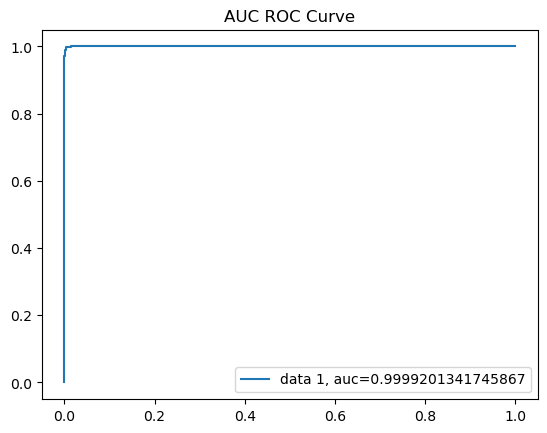

In [64]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_pred_proba =model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("AUC ROC Curve")
plt.show()

In [65]:
from sklearn.metrics import classification_report
auc = roc_auc_score(y_test, y_pred_proba) 
y_pred_binary = (y_pred_proba > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary))
print('AUC-ROC score: ', auc)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       665
         1.0       0.99      1.00      0.99       659

    accuracy                           0.99      1324
   macro avg       0.99      0.99      0.99      1324
weighted avg       0.99      0.99      0.99      1324

AUC-ROC score:  0.9999201341745867


In [66]:
np.mean(y_pred_proba)

0.5008051

In [67]:
model.save('model2.h5')
model.save_weights('my_model_weights2.h5')  # to store


In [25]:
new_data  =data_scaled[50,:]
new_data = new_data[1:]
new_data

array([0.30769231, 0.5       , 0.5       , 0.2       , 0.66666667,
       0.        , 0.13513514, 0.        , 0.        , 0.        ,
       0.17391304, 0.        , 0.        , 0.        , 0.77380952,
       0.0572479 , 0.71022727, 0.0538707 , 1.        , 0.078125  ,
       0.6       , 0.03878083, 1.        , 0.05466752, 1.        ,
       0.0285762 , 0.5       , 0.01110444, 1.        , 0.035359  ,
       0.66666667, 0.06939338, 0.        , 0.28571429, 0.02065462,
       0.85714286, 0.1520599 , 0.33333333, 0.11948529, 0.5       ,
       0.01282011, 0.        , 0.        , 0.33333333, 0.03274357,
       0.        , 0.        , 0.33333333, 0.04347426, 0.        ,
       0.        , 0.        , 0.37916667, 0.06196703, 0.61983471,
       0.18174992, 1.        , 0.04832291, 0.26923077, 0.04197766,
       0.66666667, 0.02254245, 0.625     , 0.08837666, 0.24285714,
       0.05838197, 0.5       , 0.04374143, 1.        , 0.02146106,
       0.        , 0.47945205, 0.22357242, 0.55307263, 0.15518

In [26]:

new_data = np.reshape(new_data, (1,1,new_data.shape[0]))
new_data

array([[[0.30769231, 0.5       , 0.5       , 0.2       , 0.66666667,
         0.        , 0.13513514, 0.        , 0.        , 0.        ,
         0.17391304, 0.        , 0.        , 0.        , 0.77380952,
         0.0572479 , 0.71022727, 0.0538707 , 1.        , 0.078125  ,
         0.6       , 0.03878083, 1.        , 0.05466752, 1.        ,
         0.0285762 , 0.5       , 0.01110444, 1.        , 0.035359  ,
         0.66666667, 0.06939338, 0.        , 0.28571429, 0.02065462,
         0.85714286, 0.1520599 , 0.33333333, 0.11948529, 0.5       ,
         0.01282011, 0.        , 0.        , 0.33333333, 0.03274357,
         0.        , 0.        , 0.33333333, 0.04347426, 0.        ,
         0.        , 0.        , 0.37916667, 0.06196703, 0.61983471,
         0.18174992, 1.        , 0.04832291, 0.26923077, 0.04197766,
         0.66666667, 0.02254245, 0.625     , 0.08837666, 0.24285714,
         0.05838197, 0.5       , 0.04374143, 1.        , 0.02146106,
         0.        , 0.47945205, 0

In [27]:
y_pred = model.predict(new_data)

1/1 [==============================] - 0s 362ms/step


In [28]:
y_pred

array([[0.77386403]], dtype=float32)

In [29]:
from datetime import date

today = date.today()
df_fighters_details['AGE'] = (pd.to_datetime(today) - pd.to_datetime(df_fighters_details['DOB'])).astype('<m8[Y]')

In [30]:
fighter1 = "Derrick Lewis"
fighter2= "Serghei Spivac"


In [31]:
f1_df = df_fighters.loc[df_fighters['FIGHTER']==fighter1]
f2_df = df_fighters.loc[df_fighters['FIGHTER']==fighter2]

In [32]:
f1_df

,FIGHTER,HEIGHT_fighter,WEIGHT_fighter,REACH_fighter,STANCE_fighter,Fights,Win,DRAW,Lost,No_contest,...,BODY_attemps_opponent,LEG_landed_opponent,LEG_attemps_opponent,DISTANCE_landed_opponent,DISTANCE_attemps_opponent,CLINCH_landed_opponent,CLINCH_attemps_opponent,GROUND_landed_opponent,GROUND_attemps_opponent,form_skore_fighter
594,Derrick Lewis,75.0,260.0,79.0,Orthodox,25,17,0,8,0,...,179.0,115.0,130.0,365.0,694.0,105.0,148.0,110.0,146.0,-0.7


In [33]:
df_model.columns

Index(['Win', 'HEIGHT_diff', 'REACH_diff', 'AGE_diff', 'form_skore_fighter',
       'form_skore_opponent', 'fightNo_fighter', 'fightNo_opponent',
       'Win_tot_f1', 'DRAW_f1', 'No_contest_f1', 'Win_tot_f2', 'DRAW_f2',
       'No_contest_f2', 'CTRL_pct_fighterf1', 'SIG.STR._acc_fighterf1',
       'SIG.STR._perRound_fighterf1', 'TOTAL STR._acc_fighterf1',
       'TOTAL STR._perRound_fighterf1', 'TD_acc_fighterf1',
       'TD_perRound_fighterf1', 'HEAD_acc_fighterf1',
       'HEAD_perRound_fighterf1', 'BODY_acc_fighterf1',
       'BODY_perRound_fighterf1', 'LEG_acc_fighterf1',
       'LEG_perRound_fighterf1', 'DISTANCE_acc_fighterf1',
       'DISTANCE_perRound_fighterf1', 'CLINCH_acc_fighterf1',
       'CLINCH_perRound_fighterf1', 'GROUND_acc_fighterf1',
       'GROUND_perRound_fighterf1', 'CTRL_pct_opponentf1',
       'SIG.STR._acc_opponentf1', 'SIG.STR._perRound_opponentf1',
       'TOTAL STR._acc_opponentf1', 'TOTAL STR._perRound_opponentf1',
       'TD_acc_opponentf1', 'TD_perRound_

In [34]:
agediff = df_fighters_details[df_fighters_details['FIGHTER']==fighter1]['AGE'].values[0] - df_fighters_details[df_fighters_details['FIGHTER']==fighter2]['AGE'].values[0]
formy = [f1_df['form_skore_fighter'].values[0], f2_df['form_skore_fighter'].values[0]]
no_of_fights = [f1_df['Fights'].values[0],f2_df['Fights'].values[0]]
W_D_NC = f1_df[['Win','DRAW', 'No_contest']].values.tolist()[0] + f2_df[['Win','DRAW', 'No_contest']].values.tolist()[0]

In [35]:
sloupce2 = df_fighters.columns.tolist()[10:]
stats_f1 = []
stats_f2 = []
for sloupec in sloupce2:    
    splited = sloupec.split('_')
    if 'CTRL' in splited:
        stats_f1.append((f1_df[sloupec]/f1_df['TotalTime']).values[0])
        stats_f2.append((f2_df[sloupec]/f2_df['TotalTime']).values[0])
    if 'attemps' in splited:
        stats_f1.append((f1_df[sloupec.replace('attemps', 'landed')]/f1_df[sloupec]).values[0])
        stats_f1.append((f1_df[sloupec.replace('attemps', 'landed')]/f1_df['TotalTime']).values[0]*300)
        
        stats_f2.append((f2_df[sloupec.replace('attemps', 'landed')]/f2_df[sloupec]).values[0])
        stats_f2.append((f2_df[sloupec.replace('attemps', 'landed')]/f2_df['TotalTime']).values[0]*300)
stats_list = stats_f1 + stats_f2

In [36]:
vstup = np.array([1]+[f1_df.iloc[0][col] - f2_df.iloc[0][col] for col in ['HEIGHT_fighter','REACH_fighter']] + [agediff] + formy + no_of_fights + W_D_NC + stats_list)

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
vstup_scaled = scaler.fit_transform(df_model.append(pd.DataFrame(vstup.reshape(1,-1), columns=list(df_model)), ignore_index=True))[-200:,1:]

C:\Users\spravce\AppData\Local\Temp\ipykernel_11120\2024273010.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vstup_scaled = scaler.fit_transform(df_model.append(pd.DataFrame(vstup.reshape(1,-1), columns=list(df_model)), ignore_index=True))[-200:,1:]


In [38]:
vstup_scaled.shape

(200, 89)

In [39]:
from numpy import *
where_are_NaNs = isnan(vstup_scaled)
vstup_scaled[where_are_NaNs] = 0

In [40]:
np.argwhere(np.isnan(vstup_scaled))

array([], shape=(0, 2), dtype=int64)

In [41]:
new_data = np.reshape(vstup_scaled, (1,200,vstup_scaled.shape[1]))

In [42]:
new_data

array([[[0.46153846, 0.375     , 0.47058824, ..., 0.        ,
         0.        , 0.        ],
        [0.73076923, 0.79166667, 0.41176471, ..., 0.05888578,
         0.66153846, 0.06213597],
        [0.26923077, 0.20833333, 0.58823529, ..., 0.02074561,
         0.7826087 , 0.58646617],
        ...,
        [0.46153846, 0.5       , 0.5       , ..., 0.0670209 ,
         0.25      , 0.00328931],
        [0.53846154, 0.5       , 0.5       , ..., 0.01258648,
         1.        , 0.01976735],
        [0.5       , 0.54166667, 0.76470588, ..., 0.06904736,
         0.63793103, 0.07430178]]])

In [43]:
from keras.models import load_model
model = load_model('model.h5')
model.load_weights('my_model_weights.h5')  # to load

In [44]:
y_pred = model.predict(new_data)
y_pred

1/1 [==============================] - 0s 335ms/step


array([[0.9648369]], dtype=float32)

In [69]:
df_model.to_csv('model/df_model.csv',index=False)